In [19]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import secrets
import contractions
import re
import seaborn as sns
import matplotlib.pyplot as plt
import lyricsgenius
from datetime import datetime
from collections import Counter
import spacy
from spacy.attrs import LOWER, POS, ENT_TYPE, IS_ALPHA, DEP, LEMMA, LOWER, IS_PUNCT, IS_DIGIT, IS_SPACE, IS_STOP
from spacy.tokens import Doc
import importlib

In [2]:
genius = lyricsgenius.Genius(secrets.GENIUS_ACCESS_TOKEN)
nlp = spacy.load("en_core_web_sm")

In [3]:
def remove_tokens(doc, index_to_del, list_attr=[LOWER, POS, ENT_TYPE, IS_ALPHA, DEP, LEMMA, LOWER, IS_PUNCT, IS_DIGIT, IS_SPACE, IS_STOP]):
    # https://gist.github.com/Jacobe2169/5086c7c4f6c56e9d3c7cfb1eb0010fe8
    """
    Remove tokens from a Spacy *Doc* object without losing 
    associated information (PartOfSpeech, Dependance, Lemma, extensions, ...)
    
    Parameters
    ----------
    doc : spacy.tokens.doc.Doc
        spacy representation of the text
    index_to_del : list of integer 
         positions of each token you want to delete from the document
    list_attr : list, optional
        Contains the Spacy attributes you want to keep (the default is 
        [LOWER, POS, ENT_TYPE, IS_ALPHA, DEP, LEMMA, LOWER, IS_PUNCT, IS_DIGIT, IS_SPACE, IS_STOP])
    Returns
    -------
    spacy.tokens.doc.Doc
        Filtered version of doc
    """
    
    np_array = doc.to_array(list_attr) # Array representation of Doc
    
    # Creating a mask: boolean array of the indexes to delete
    mask_to_del = np.ones(len(np_array), np.bool)
    mask_to_del[index_to_del] = 0
    
    np_array_2 = np_array[mask_to_del]
    doc2 = Doc(doc.vocab, words=[t.text for t in doc if t.i not in index_to_del])
    doc2.from_array(list_attr, np_array_2)
    
    ### Modification made by @yarongon https://gist.github.com/Jacobe2169/5086c7c4f6c56e9d3c7cfb1eb0010fe8#gistcomment-2941380
    # Handling user extensions
    #  The `doc.user_data` dictionary is holding the data backing user-defined attributes.
    #  The data is based on characters offset, so a conversion is needed from the
    #  old Doc to the new one.
    #  More info here: https://github.com/explosion/spaCy/issues/2532
    arr = np.arange(len(doc))
    new_index_to_old = arr[mask_to_del]
    doc_offset_2_token = {tok.idx : tok.i  for tok in doc}  # needed for the user data
    doc2_token_2_offset = {tok.i : tok.idx  for tok in doc2}  # needed for the user data
    new_user_data = {}
    for ((prefix, ext_name, offset, x), val) in doc.user_data.items():
        old_token_index = doc_offset_2_token[offset]
        new_token_index = np.where(new_index_to_old == old_token_index)[0]
        if new_token_index.size == 0:  # Case this index was deleted
            continue
        new_char_index = doc2_token_2_offset[new_token_index[0]]
        new_user_data[(prefix, ext_name, new_char_index, x)] = val
    doc2.user_data = new_user_data
    
    return doc2

In [4]:
def expand_contractions(text, contraction_mapping=contractions.CONTRACTION_MAP):
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
#     contractions_pattern = re.compile('|'.join(contraction_mapping.keys()), 
#                                       flags=re.IGNORECASE|re.DOTALL)
#     print(contractions_pattern.pattern)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())  
        if first_char != "'":
            expanded_contraction = first_char+expanded_contraction[1:]
#         print(match + ": "+ expanded_contraction)
        return expanded_contraction
        
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    text = expanded_text
    return text

In [5]:
def is_good_adlib(span):
    #list of (start, end)
    all_pos = [token.pos_ for token in span]
    all_dep = [token.dep_ for token in span]
    
    #if the span contains a verb and subject, then it is a good adlib
    if("VERB" in all_pos and "nsubj" in all_dep):
        return True
    return False

def remove_adlibs(text):
    lyric = nlp(text)
    in_paranthesis = False
    start_idx = -1
    end_idx = -1
    adlibs = []
    for token in lyric:
        if (token.text == '(' and not in_paranthesis):
            start_idx = token.i
            in_paranthesis = True
        elif (token.text == ')' and in_paranthesis):
            end_idx = token.i + 1
            adlibs.append((start_idx, end_idx))
            in_paranthesis = False
    
    bad_ranges = []
    for (start, end) in adlibs:
        if(not is_good_adlib(lyric[start:end])):
            bad_ranges.append((start, end))
            
    #remove all words from bad ranges
    to_remove = []
    for (start, end) in bad_ranges:
        for i in range(start, end):
            to_remove.append(i)
    
    lyric = remove_tokens(lyric, to_remove)
    text = str(lyric)
    return text

In [6]:
#add spacy data
def add_spacy_data(dataset):
    
    verbs = []
    nouns = []
    adverbs = []
    corpus = []
    entities = []
    for i in range(0, len(dataset)):
        print("SpaCy now processing {} by {}".format(dataset.iloc[i]['Song Title'], dataset.iloc[i]['Artist']))
        song = dataset.iloc[i]["Lyrics"]
        doc = nlp(song)
        spacy_df = pd.DataFrame()
        for token in doc:
            row = {
                "word": token.text,
                "lemma": token.lemma_ if token.lemma_ != "-PRON-" else token.text ,
                "pos": token.pos_,
                "stop word": token.is_stop,
            }
            spacy_df = spacy_df.append(row, ignore_index=True)
        verbs.append(" ".join(spacy_df['lemma'][spacy_df["pos"] == "VERB"].values))
        nouns.append(" ".join(spacy_df['lemma'][spacy_df["pos"] == "NOUN"].values))
        adverbs.append(" ".join(spacy_df['lemma'][spacy_df["pos"] == "ADV"].values))
        corpus1 = " ".join(spacy_df['lemma'][spacy_df["stop word"] == False].values)
        corpus1 = re.sub(r'[^A-Za-z0-9]+', ' ', corpus1)
        corpus.append(corpus1)
        entities.append(", ".join(str(ent) for ent in doc.ents))
    dataset['Verbs'] = verbs
    dataset['Nouns'] = nouns
    dataset['Adverbs'] = adverbs
    dataset['Corpus'] = corpus
    dataset['Entities'] = entities
    return dataset

In [7]:
def get_billboard_from_year(start_year, end_year):
    years = np.arange(start_year, end_year + 1).astype(int)
    top_songs = pd.DataFrame()

    for i in range(0, len(years)):
        year = years[i]
        print("Collecting songs from %i...", year)
        url = "https://www.billboard.com/charts/year-end/"+ str(year) +"/hot-100-songs"
        
        billboard_page = requests.get(url)
        soup = BeautifulSoup(billboard_page.text, "html.parser")

        titles = [div.text for div in soup.find_all("div", "ye-chart-item__title")]
        ranks = [div.text for div in soup.find_all("div", "ye-chart-item__rank")]
        artists = [div.text for div in soup.find_all("div", "ye-chart-item__artist")]

        for i in range(0, len(ranks)):
            row = {
                "Rank": ranks[i].replace("\n", "").strip(),
                "Song Title": titles[i].replace("\n", "").strip(),
                "Artist": artists[i].replace("\n", "").strip(),
                "Year": int(year)
            }
            top_songs = top_songs.append(row, ignore_index=True)
    return top_songs

In [41]:
def get_feature_frequencies_by_year(dataset, feature_column):
    frequencies = pd.DataFrame()
    years = dataset["Year"].unique().tolist()
    for i in range(0, len(years)):
        year_tokens = str(genius_spacy_data[feature_column][genius_spacy_data['Year'] == years[i]].tolist()).split(" ")
        word_counts = Counter(year_tokens)
        average_tokens = 
        frequencies = frequencies.append({
            "Year": years[i],
            "Most Common " + feature_column: word_counts.most_common(n=100)
        }, ignore_index=True)
    frequencies['Year'] = frequencies['Year'].astype(int)
    return frequencies

In [61]:
def get_average_term_frequencies(dataset):
    averages = pd.DataFrame()
    years = dataset["Year"].unique().tolist()
    for i in range(0, len(years)):
        row= {
            "Year": years[i],
            "Average Words": genius_spacy_data["Word Count"][genius_spacy_data['Year'] == years[i]].mean(),
            "Average Unique Words": genius_spacy_data["Unique Word Count"][genius_spacy_data['Year'] ==years[i]].mean()
        }
        averages = averages.append(row, ignore_index = True)
    averages['Year'] = averages['Year'].astype(int)
    return averages

In [8]:
#1. get top songs from range of years
all_songs = get_billboard_from_year(2019, 2019)

In [9]:
display(all_songs.head(5))
display(all_songs.shape)

,Artist,Rank,Song Title,Year
0,Lil Nas X Featuring Billy Ray Cyrus,1,Old Town Road,2019.0
1,Post Malone & Swae Lee,2,Sunflower (Spider-Man: Into The Spider-Verse),2019.0
2,Halsey,3,Without Me,2019.0
3,Billie Eilish,4,Bad Guy,2019.0
4,Post Malone,5,Wow.,2019.0


(100, 4)

In [10]:
#2. search & copy data from genius for each song

starttime = datetime.now()
print("Starting: " + str(starttime))
all_song_data = pd.DataFrame()
for i in range(0, len(all_songs)):
    song = all_songs.iloc[i]

    try:
        song_data = genius.search_song(song['Song Title'], song["Artist"])
#         print(dir(song_data))
        if(song_data):
            song_album = song_data.album
            featured_artists = song_data.featured_artists
            song_lyrics = song_data.lyrics.replace("\n", " ")
            song_media = song_data.media
            song_url = song_data.url
            song_writer_artists = song_data.writer_artists
            song_producer_artists = song_data.producer_artists if song_data.producer_artists else ""
            song_album_url = song_data.album_url
            song_release_year = song_data.year
    except:
        song_album = "null"
        song_album_url = "null"
        featured_artists = "null"
        song_lyrics = "null"
        song_media = "null"
        song_url = "null"
        song_writer_artists = "null"
        song_release_year = "null"
        song_producer_artists = song_data.producer_artists
        song_album_url = song_data.album_url
        song_release_year = song_data.year
        
    row = {
        "Year": song['Year'],
        "Charting Rank": song['Rank'],
        "Song Title": song['Song Title'],
        "Artist": song['Artist'],
        "Album": song_album ,
        "Producers": song_producer_artists,
        "Writers": song_writer_artists,
        "Album URL": song_album_url,
        "Featured Artists": featured_artists,
        "Lyrics":  song_lyrics,
        "URL": song_url,
        "Media": song_media,
        "Release Year": song_release_year
    }
    all_song_data = all_song_data.append(row, ignore_index=True)

endtime = datetime.now()
print("Finished Job: " + str(endtime))
print("Elapsed Time: " + str(endtime - starttime))


Starting: 2020-05-23 11:18:36.487095
Searching for "Old Town Road" by Lil Nas X Featuring Billy Ray Cyrus...
Done.
Searching for "Sunflower (Spider-Man: Into The Spider-Verse)" by Post Malone & Swae Lee...
Done.
Searching for "Without Me" by Halsey...
Done.
Searching for "Bad Guy" by Billie Eilish...
Done.
Searching for "Wow." by Post Malone...
Done.
Searching for "Happier" by Marshmello & Bastille...
Done.
Searching for "7 Rings" by Ariana Grande...
Done.
Searching for "Talk" by Khalid...
Done.
Searching for "Sicko Mode" by Travis Scott...
Done.
Searching for "Sucker" by Jonas Brothers...
Done.
Searching for "High Hopes" by Panic! At The Disco...
Done.
Searching for "Thank U, Next" by Ariana Grande...
Done.
Searching for "Truth Hurts" by Lizzo...
Done.
Searching for "Dancing With A Stranger" by Sam Smith & Normani...
Done.
Searching for "Senorita" by Shawn Mendes & Camila Cabello...
Done.
Searching for "I Don't Care" by Ed Sheeran & Justin Bieber...
Done.
Searching for "Eastside" by b

In [11]:
# save the data to file. 
# genius_song_data = all_song_data
# genius_song_data.to_pickle(r"stored_song_data.pickle")

In [8]:
# load data from file
genius_song_data = pd.read_pickle("stored_song_data.pickle")

In [49]:
#3. clean the lyric data
importlib.reload(contractions)
for i in range(0, len(genius_song_data)):
    song = genius_song_data.iloc[i]
    expanded = expand_contractions(song['Lyrics'])
    cleaned = remove_adlibs(expanded)
    genius_song_data.at[i, 'Lyrics'] = cleaned

In [12]:
#4. add spacy data
genius_spacy_data = add_spacy_data(genius_song_data)

SpaCy now processing Old Town Road by Lil Nas X Featuring Billy Ray Cyrus
SpaCy now processing Sunflower (Spider-Man: Into The Spider-Verse) by Post Malone & Swae Lee
SpaCy now processing Without Me by Halsey
SpaCy now processing Bad Guy by Billie Eilish
SpaCy now processing Wow. by Post Malone
SpaCy now processing Happier by Marshmello & Bastille
SpaCy now processing 7 Rings by Ariana Grande
SpaCy now processing Talk by Khalid
SpaCy now processing Sicko Mode by Travis Scott
SpaCy now processing Sucker by Jonas Brothers
SpaCy now processing High Hopes by Panic! At The Disco
SpaCy now processing Thank U, Next by Ariana Grande
SpaCy now processing Truth Hurts by Lizzo
SpaCy now processing Dancing With A Stranger by Sam Smith & Normani
SpaCy now processing Senorita by Shawn Mendes & Camila Cabello
SpaCy now processing I Don't Care by Ed Sheeran & Justin Bieber
SpaCy now processing Eastside by benny blanco, Halsey & Khalid
SpaCy now processing Going Bad by Meek Mill Featuring Drake
SpaCy n

In [13]:
# save data to file
# genius_spacy_data.to_pickle(r"stored_song_data_with_spacy.pickle")

In [9]:
# load data from file
genius_spacy_data =  pd.read_pickle("stored_song_data_with_spacy.pickle")

In [62]:
#4a. calculate count of unique words in year, average words per songs
word_counts = []
unique_counts = []
for i in range(0, len(genius_spacy_data)):
    word_counts.append(len(genius_spacy_data.iloc[i]['Lyrics'].split()))
    unique_counts.append(len(set(genius_spacy_data.iloc[i]['Lyrics'].split())))
genius_spacy_data['Word Count'] = word_counts
genius_spacy_data['Unique Word Count'] = unique_counts

year_summary = get_average_term_frequencies(genius_spacy_data)

In [63]:
# save data to file
genius_spacy_data.to_pickle(r"stored_song_data_with_spacy_word_counts.pickle")
year_summary.to_pickle(r"yearly_averages.pickle")

In [64]:
# load data from file
# genius_spacy_data =  pd.read_pickle("stored_song_data_with_spacy_word_counts.pickle")
# year_summary = pd.read_pickle("yearly_averages.pickle")

In [54]:
display(genius_spacy_data.head())

,Album,Album URL,Artist,Charting Rank,Featured Artists,Lyrics,Media,Producers,Release Year,Song Title,URL,Writers,Year,Verbs,Nouns,Adverbs,Corpus,Entities,Word Count,Unique Word Count
0,"Diplo Presents Thomas Wesley, Chapter 1: Snake...",https://genius.com/albums/Diplo/Diplo-presents...,Lil Nas X Featuring Billy Ray Cyrus,1,[],"[Intro: Billy Ray Cyrus] Oh, oh-oh Oh [Refrai...","[{'attribution': 'diplo', 'provider': 'soundcl...","[{'api_path': '/artists/1756072', 'header_imag...",2019-05-02,Old Town Road,https://genius.com/Lil-nas-x-billy-ray-cyrus-a...,"[{'api_path': '/artists/60166', 'header_image_...",2019.0,go take go ride can go take go ride can get at...,refrain horse town road horse town road horse ...,til more til more up now down so back til more...,Intro Billy Ray Cyrus oh oh oh oh refrain Bil...,"Intro, Billy Ray Cyrus, Billy Ray Cyrus, Verse...",388,110
1,None,None,Post Malone & Swae Lee,2,[],"Author: Jorge Ramos You did read it, and it wi...",[],,2019-10-07,Sunflower (Spider-Man: Into The Spider-Verse),https://genius.com/Jorja-smith-virtual-reality...,[],2019.0,read will happen join perform schedule will ta...,author list artist reality concert place app h...,recently so most back also when together later...,author Jorge Ramos read happen Post Malone rec...,"Jorge Ramos, 17, October, Raleigh, PNC Arena, ...",672,376
2,Manic (Target Exclusive),https://genius.com/albums/Halsey/Manic-target-...,Halsey,3,[],[Verse 1] Found you when your heart was broke ...,"[{'provider': 'youtube', 'start': 0, 'type': '...","[{'api_path': '/artists/143754', 'header_image...",2018-10-04,Without Me,https://genius.com/Halsey-without-me-lyrics,"[{'api_path': '/artists/2080714', 'header_imag...",2019.0,find break fill overflow take keep keep leave ...,heart cup knee foot advantage one name sky one...,when so far then then right back just how up t...,Verse 1 find heart break fill cup overflow ta...,"[Pre-Chorus, sittin, Feelin, Thinkin, Hundred,...",445,144
3,"WHEN WE ALL FALL ASLEEP, WHERE DO WE GO? (Japa...",https://genius.com/albums/Billie-eilish/When-w...,Billie Eilish,4,[],"[Verse 1] White shirt now red, my bloody nose ...",[{'native_uri': 'spotify:track:2Fxmhks0bxGSBdJ...,"[{'api_path': '/artists/615565', 'header_image...",2019-03-29,Bad Guy,https://genius.com/Billie-eilish-bad-guy-lyrics,"[{'api_path': '/artists/615550', 'header_image...",2019.0,know think say thank want want can make make m...,shirt nose toe creepin one bruise knee soul gu...,now around so when so so really just always so...,Verse 1 white shirt red bloody nose Sleepin t...,"Verse 1] White, Sleepin, Creepin, Bruises, Pos...",267,138
4,Hollywood’s Bleeding,https://genius.com/albums/Post-malone/Hollywoo...,Post Malone,5,[],"[Verse 1] Said she tired of little money, need...","[{'provider': 'youtube', 'start': 6, 'type': '...","[{'api_path': '/artists/143754', 'header_image...",2018-12-24,Wow.,https://genius.com/Post-malone-wow-lyrics,"[{'api_path': '/artists/28169', 'header_image_...",2019.0,say tire need pull need mix get fall know piss...,money boy inch blade flockin shawty vodka hous...,now up up back when when deep when when probab...,Verse 1 say tire little money need big boy pu...,"20 inch, Shawty, LaCroix, G-Wagen, G-Wagen, G-...",405,207


In [42]:
#4b. calculate common terms and counts of each
adverbs_frequencies = get_feature_frequencies_by_year(genius_spacy_data, "Adverbs")
nouns_frequencies = get_feature_frequencies_by_year(genius_spacy_data, "Nouns")
verbs_frequencies = get_feature_frequencies_by_year(genius_spacy_data, "Verbs")
word_frequencies = get_feature_frequencies_by_year(genius_spacy_data, "Corpus")
entity_frequencies = get_feature_frequencies_by_year(genius_spacy_data, "Entities")

adverbs

In [65]:
display(nouns_frequencies.iloc[0])
display(verbs_frequencies.iloc[0])
display(adverbs_frequencies.iloc[0])
display(word_frequencies.iloc[0])
display(entity_frequencies.iloc[0])

display(year_summary)

Most Common Nouns    [(feat, 279), (bitch, 155), (shit, 140), (baby...
Year                                                              2019
Name: 0, dtype: object

Most Common Verbs    [(get, 463), (know, 319), (be, 285), (say, 270...
Year                                                              2019
Name: 0, dtype: object

Most Common Adverbs    [(just, 238), (when, 237), (so, 211), (now, 16...
Year                                                                2019
Name: 0, dtype: object

Most Common Corpus    [(2018, 1639), (yeah, 653), (like, 459), (get,...
Year                                                               2019
Name: 0, dtype: object

Most Common Entities    [(2018,, 1423), (&, 235), (2017,, 157), (the, ...
Year                                                                 2019
Name: 0, dtype: object

,Average Unique Words,Average Words,Year
0,228.87,592.53,2019


In [ ]:
#testing
ti =5 #3 = humble 5 = bad and boujee
song = genius_spacy_data.iloc[ti]
lyrics = song['Lyrics']
lyrics_contr = expand_contractions(lyrics)
doc = nlp(lyrics_contr)
cleaned = remove_adlibs(lyrics_contr)
print (cleaned)


In [25]:
#testing
doc = nlp("i want to get this back as a string")
print(str(doc))
assert str(doc) == "i want to get this back as a string"

i want to get this back as a string


In [14]:
df = pd.DataFrame(np.random.rand(10, 5), columns=['A', 'B', 'C', 'D', 'E'])

,A,B,C,D,E
0,0.146719,0.069909,0.388172,0.213258,0.777216
1,0.430206,0.588375,0.097673,0.706828,0.455461
2,0.898796,0.637269,0.612052,0.085287,0.505442
3,0.396513,0.625571,0.441940,0.531714,0.304634
4,0.113844,0.415921,0.271192,0.197504,0.927510


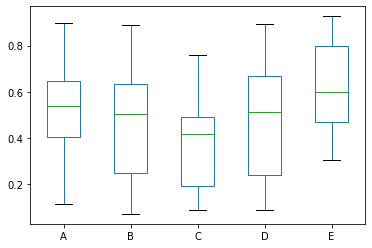

In [17]:
display(df.head())
df.plot.box()